In [1]:
import numpy as np
from os import path, environ
from skimage import io
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import ipywidgets as widgets
from sklearn.metrics import accuracy_score
environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # suppress TensorFlow info messages

In [2]:
import A1.models as A1, A2.models as A2, B1.models as B1, B2.models as B2

Function for loading data

In [3]:
LABELS = 'labels.csv'
DATASETS = 'Datasets'
IMGS = 'img'
TEST = '_test'

def load_data(folder, feature_col, file_col, load_image, augment=False):
    filenames, y = np.genfromtxt(
        path.join(DATASETS,folder,LABELS),
        usecols=(file_col,feature_col),
        dtype='U10,i8',
        unpack=True,
        skip_header=1,
        delimiter='\t'
    )
    y = np.maximum(y,0) # convert -1 label to 0
    imagedir = path.join(DATASETS,folder,IMGS)
    n = len(filenames)
    shape = load_image(path.join(imagedir,filenames[0])).shape # get first image to get shape
    X = np.empty((n*2 if augment else n, *shape), dtype=np.uint8) # pre-define X, much more efficient than concatenating arrays
    for i in tqdm(range(n), desc=folder): # tqdm displays a nice loading bar
        X[i] = load_image(path.join(imagedir,filenames[i]))
    if augment:
        X[n:] = X[:n,:,::-1]  # copy images, but reverse left to right
        y = np.tile(y,2) # duplicate labels
    print(f'Loaded {X.nbytes:,} bytes')
    return X, y


Each task uses a different comibination of dataset, feature_col, file_col, and module:

In [4]:
TASKS = {'A1':('celeba',2,1,A1), 'A2':('celeba',3,1,A2), 'B1':('cartoon_set',2,3,B1),'B2':('cartoon_set',1,3,B2)}
task = widgets.Dropdown(options=TASKS, description='Task')

In [6]:
task

Dropdown(description='Task', index=3, options={'A1': ('celeba', 2, 1, <module 'A1.models' from '/Users/marc/Pr…

In [7]:
dataset, feature_col, file_col, models = task.value

In [8]:
augment = task.label.startswith('A') # only augment 'A' tasks
X, y = load_data(dataset, feature_col, file_col, models.load_image, augment=augment)

cartoon_set:   0%|          | 0/10000 [00:00<?, ?it/s]

Loaded 216,000,000 bytes


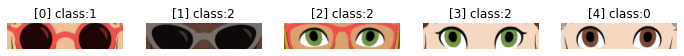

In [9]:
plt.figure(figsize=(12,6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.title(f'[{i}] class:{y[i]}')
    plt.imshow(X[i], cmap='gray')
plt.show()

In [10]:
opts = {**A1.options, **A2.options, **B1.options, **B2.options}
selected = list(models.options.values())[0]
options = widgets.Dropdown(options=opts, value=selected, description='Model', layout=widgets.Layout(width='50%'))

In [28]:
options

Dropdown(description='Model', index=5, layout=Layout(width='50%'), options={'Best A1: Clahe, PCA(120) & SVC Ha…

In [29]:
model = options.value

In [13]:
X_test, y_test = load_data(dataset+TEST, feature_col, file_col, models.load_image)

cartoon_set_test:   0%|          | 0/2500 [00:00<?, ?it/s]

Loaded 54,000,000 bytes


Performing Principle Component Analysis...


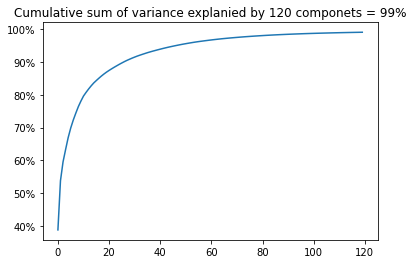

Performing Support Vector Classification Fit...
Accuracy on trained data: 86.16%


In [30]:
print(f"Accuracy on trained data: {model.fit(X, y):.2%}")

In [31]:
y_pred = model.predict(X_test)

In [32]:
print(f"Accuracy on test data: {accuracy_score(y_test,y_pred):.2%}")

Accuracy on test data: 84.28%


In [ ]:
wrong, = np.nonzero(y_test!=y_pred)
print(f'There were {len(wrong)} wrong predictions out of {len(y_test)}')
for w,i in enumerate(wrong):
    if w%5==0: plt.figure(figsize=(12,3))
    plt.subplot(1, 5, w%5+1)
    plt.axis('off')
    plt.title(f'[{i}] class:{y_test[i]} pred:{y_pred[i]}')
    plt.imshow(X_test[i], cmap='gray')
    if w%5==4: plt.show()
